In [ ]:
import os
# os.environ["JAX_DEBUG_NANS"] = "True"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [1]:
import matplotlib.pyplot as plt

import time
import jax
import jax.numpy as jnp
from jax import random, vmap

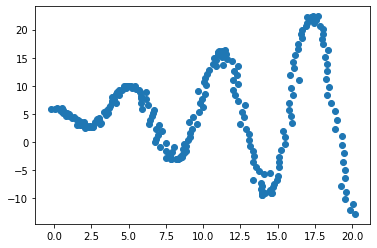

In [2]:
key = random.PRNGKey(100)

num_points = 250
noisy_x = 0.2 * random.normal(key, shape=(num_points,))
noisy_y = 0.1 * random.normal(key, shape=(num_points,))

x = jnp.linspace(0, 20, num_points)

def fn(x):
    return 5.0 - x * jnp.sin(x) + jnp.cos(x)

y = vmap(fn)(x)

X = x + noisy_x
Y = y + noisy_y
plt.scatter(X, Y)

In [3]:
x = x.reshape((-1, 1))
X = X.reshape((-1, 1))
Y = Y.reshape((-1, 1))

In [4]:
jax.devices()

[GpuDevice(id=0)]

In [5]:
from jax.experimental.optimizers import adam

lr = 0.1
num_steps = 1000
num_hidden = 20

def act(x):
    return jnp.exp(- (x ** 2.0))

def rbf_network(x, params):
    batchsize = x.shape[0]
    w1, b1, w2, b2 = params
    x = x @ w1 + b1
    x = act(x)
    x = x @ w2 + b2
    return x

def loss(x, y, params):
    batchsize = x.shape[0]
    diff = y - rbf_network(x, params)
    l = jnp.sum(diff * diff)
    return (1.0/batchsize) * l


w1 = random.uniform(key, shape=(1, num_hidden)) * 0.2
b1 = jnp.zeros((1,num_hidden))
w2 = random.uniform(key, shape=(num_hidden, 1)) * 0.2
b2 = jnp.zeros((1,1))

params = (w1, b1, w2, b2)

opt_init, opt_update, get_params = adam(step_size=lr)
opt_state = opt_init(params)

# loss_and_grad_loss = jax.value_and_grad(loss, argnums=2)
loss_and_grad_loss = jax.jit(jax.value_and_grad(loss, argnums=2))

@jax.jit # <--- without this jit, jax is about magnitudes slower than pytorch
def train_step(step, x, y, opt_state):
    loss, grads = loss_and_grad_loss(x, y, get_params(opt_state))
    opt_state = opt_update(step, grads, opt_state)
    return loss, opt_state

last_timestamp = time.time()
for step in range(num_steps):
    loss, opt_state = train_step(step, X, Y, opt_state)
    if (step+1) % 100 == 0:
        print("Epoch: {:>4} loss: {:>.5} time takes: {:>.3}s".format(step + 1, loss, time.time() - last_timestamp))
        last_timestamp = time.time()

Epoch:  100 loss: 61.004 time takes: 0.796s
Epoch:  200 loss: 18.624 time takes: 0.301s
Epoch:  300 loss: 4.6001 time takes: 0.275s
Epoch:  400 loss: 3.3683 time takes: 0.277s
Epoch:  500 loss: 4.9026 time takes: 0.278s
Epoch:  600 loss: 3.2051 time takes: 0.285s
Epoch:  700 loss: 4.2544 time takes: 0.272s
Epoch:  800 loss: 3.1525 time takes: 0.281s
Epoch:  900 loss: 3.0497 time takes: 0.295s
Epoch: 1000 loss: 2.7356 time takes: 0.283s


In [6]:
y_pred = rbf_network(x, get_params(opt_state))

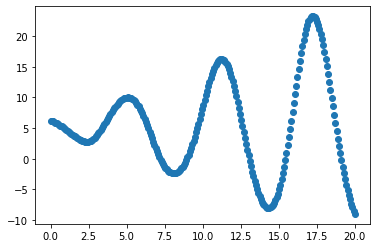

In [7]:
plt.scatter(x, y_pred.flatten())